# Week4: NLP Disaster Tweets Kaggle Mini-Project
2023.10.14 D.Ikoma

## 1. Brief description of the problem and data
### 1-1. Introduction

X/Twitter has become an important communication channel in times of emergency. The ubiquitousness of smartphones enables people to announce an emergency they are observing in real-time. A machine learning model is built, that would predict which tweets are about real disasters and which ones are not.

### 1-2. Import libraries
We will import python libraries required for this project.

In [34]:
# Basic libraries
import os
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Libraries for visualisation
import seaborn as sns
import matplotlib.pyplot as plt

# Libraries for formattting and handling text 
import string 
import re

# Library for nltk
import nltk
from nltk.corpus import stopwords
from nltk.tokenize import sent_tokenize, word_tokenize
from nltk.stem import PorterStemmer, WordNetLemmatizer
#from wordcloud import WordCloud, STOPWORDS

# Library for Splitting Dataset
from sklearn.model_selection import train_test_split

# Libraries for NN
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras import optimizers
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Embedding, LSTM, Dropout
from tensorflow.keras.utils import plot_model

# Library for evaluation
from sklearn import metrics
from functools import reduce
from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report

import warnings
warnings.filterwarnings("ignore")

### 1-3. Import data
First, we will check data files and import them. Next, we will take a look at them.

In [35]:
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

/kaggle/input/nlp-getting-started/sample_submission.csv
/kaggle/input/nlp-getting-started/train.csv
/kaggle/input/nlp-getting-started/test.csv


In [36]:
train_data = pd.read_csv('/kaggle/input/nlp-getting-started/train.csv')
train_data.sample(5)

,id,keyword,location,text,target
5314,7588,outbreak,kano,Families to sue over Legionnaires: More than 4...,1
7114,10193,violent%20storm,"Newcastle, OK",I think that none of us know the impact we hav...,0
5110,7289,nuclear%20disaster,Under Santa Barbara Skies,70 years ago today 1945 #Hiroshima was the fir...,1
1131,1631,bombing,NaN,The United Kingdom and France are bombing Daes...,1
354,509,army,"Memphis, TN",Salvation Army hosts rally to reconnect father...,1


The training data includes 'id,' 'keyword,' 'location,' and 'text.' Additionally, it is indicated as either 1 or 0 to determine whether it is related to a disaster as the 'target'.

In [37]:
test_data = pd.read_csv('/kaggle/input/nlp-getting-started/test.csv')
test_data.sample(5)

,id,keyword,location,text
622,2029,casualties,Ngayogyakarta Hadiningrat,Memorial day of 70 years Hiroshima and Nagasak...
1165,3847,detonate,Boulder via DC,First Stearns grenade thought to be WWII-era. ...
2971,9827,trauma,NaN,@MountSinaiNYC @Beingtweets @Susancares2x #onb...
2706,9014,stretcher,NaN,Oh no! Dan Hughes seems like he's really hurt ...
1236,4066,displaced,magodo,#mightyworld Thousands displaced after monsoon...


In [38]:
print("Train data: Number of rows is = ", train_data.shape[0], " Number of columns is = " , train_data.shape[1]) 
print("Test  data: Number of rows is = ", test_data.shape[0], " Number of columns is = " , test_data.shape[1]) 

Train data: Number of rows is =  7613  Number of columns is =  5
Test  data: Number of rows is =  3263  Number of columns is =  4


The dataset comprises a total of 10,876 data points, with approximately 70% in the training dataset and approximately 30% in the test dataset.

## 2. Exploratory Data Analysis (EDA)
### 2-1. Target distribution
First, we will examine the distribution of 'target' in the training data, where 0 represents non-disaster and 1 represents disaster.

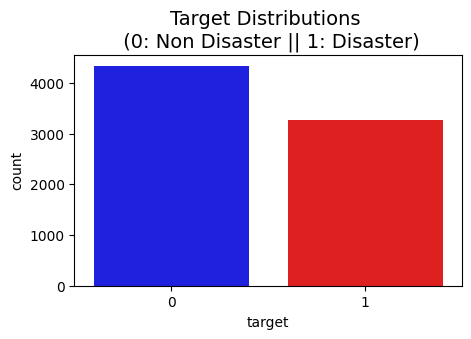

target
0    4342
1    3271
Name: count, dtype: int64

In [39]:
plt.figure(figsize=(5,3))
colors = ["blue", "red"]

sns.countplot(x = 'target', data=train_data, palette=colors)
plt.title('Target Distributions \n (0: Non Disaster || 1: Disaster)', fontsize=14)
plt.show()
train_data['target'].value_counts()

Non-disaster (0) has 4,342 occurrences, and Disaster (1) has 3,271, for a total of 7,613. The balance between 1 and 0 is not extremely skewed, and we have determined that there is no need for equalization techniques like over/under-sampling.

### 2-2. Top 20 keywords
We will check the top 20 keywords in descending order of frequency for both 'Non-disaster' and 'Disaster' cases.

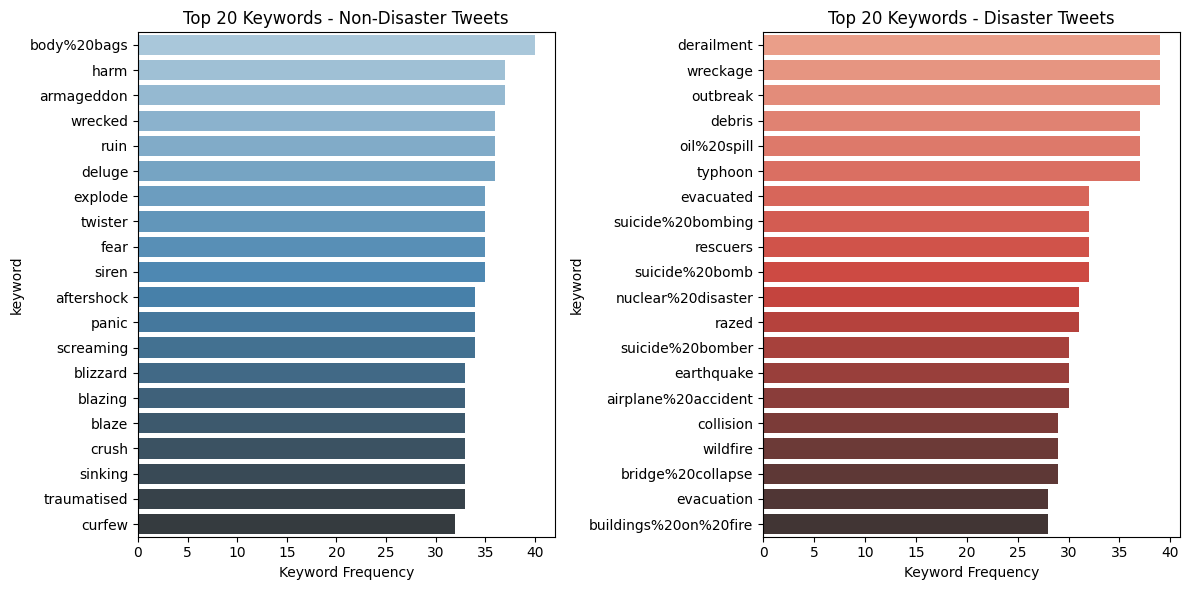

In [40]:
nondisaster_keywords = train_data.loc[train_data["target"] == 0]["keyword"].value_counts()
disaster_keywords = train_data.loc[train_data["target"] == 1]["keyword"].value_counts()

fig, ax = plt.subplots(1,2, figsize=(12,6))
sns.barplot(y=nondisaster_keywords[0:20].index, x=nondisaster_keywords[0:20], orient='h', ax=ax[0], palette="Blues_d")
ax[0].set_title("Top 20 Keywords - Non-Disaster Tweets")
ax[0].set_xlabel("Keyword Frequency")

sns.barplot(y=disaster_keywords[0:20].index, x=disaster_keywords[0:20], orient='h', ax=ax[1], palette="Reds_d")
ax[1].set_title("Top 20 Keywords - Disaster Tweets")
ax[1].set_xlabel("Keyword Frequency")

plt.tight_layout()
plt.show()

In Disaster tweets, there is a high frequency of direct disaster-related keywords, such as 'typhoon,' 'earthquake,' and 'outbreak.' On the other hand, in Non-disaster tweets, there is a tendency for more abstract keywords like 'fear,' 'panic,' and 'harm' to be prevalent. However, simple word frequency alone makes classification challenging, and an analysis with LSTM considering context is necessary.

### 2-3. Text length distribution
We can create a column length in train_data, which will have length of each text. Subsequently, we will display the distribution of text length using a histogram.

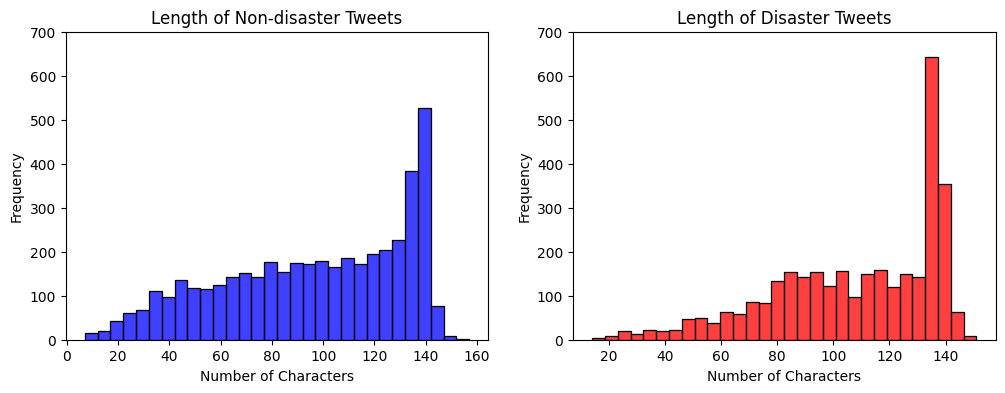

In [41]:
train_data["length"]  = train_data["text"].apply(len)

# Filter the data for target = 0 and target = 1
target_0_data = train_data[train_data["target"] == 0]
target_1_data = train_data[train_data["target"] == 1]

# Create subplots for side-by-side histograms
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 4))

# Plot the histogram for target = 0
sns.histplot(target_0_data["length"], color='blue', bins=30, ax=ax1)
ax1.set_title("Length of Non-disaster Tweets")
ax1.set_xlabel("Number of Characters")
ax1.set_ylabel("Frequency")
ax1.set_ylim(0, 700)  # Set y-axis upper limit to 700

# Plot the histogram for target = 1
sns.histplot(target_1_data["length"], color='red', bins=30, ax=ax2)
ax2.set_title("Length of Disaster Tweets")
ax2.set_xlabel("Number of Characters")
ax2.set_ylabel("Frequency")
ax2.set_ylim(0, 700)  # Set y-axis upper limit to 700

plt.show()

There is a peak in the 130-character range, and these texts are the main focus of analysis. The distribution trends do not vary significantly between Non-disaster and Disaster tweets, but there is a tendency for Disaster tweets to be longer. This suggests that there is a higher likelihood of these tweets trying to convey a situation accurately.

### 2-4. Text preprocessing
We can create a function 'toclean_text' to remove punctuations, and then it can used to clean text column of training data.

In [42]:
def toclean_text(text):
    clean_text = [char for char in text if char not in string.punctuation]
    clean_text = ''.join(clean_text)
    return clean_text

Function 'toclean_text', will remove punctuations in a text. Now we apply it to training data and create a column clean_text for the training data, which will have text without puntuations.

In [43]:
train_data['clean_text'] = train_data['text'].apply(toclean_text)
train_data.head()

,id,keyword,location,text,target,length,clean_text
0,1,NaN,NaN,Our Deeds are the Reason of this #earthquake M...,1,69,Our Deeds are the Reason of this earthquake Ma...
1,4,NaN,NaN,Forest fire near La Ronge Sask. Canada,1,38,Forest fire near La Ronge Sask Canada
2,5,NaN,NaN,All residents asked to 'shelter in place' are ...,1,133,All residents asked to shelter in place are be...
3,6,NaN,NaN,"13,000 people receive #wildfires evacuation or...",1,65,13000 people receive wildfires evacuation orde...
4,7,NaN,NaN,Just got sent this photo from Ruby #Alaska as ...,1,88,Just got sent this photo from Ruby Alaska as s...


Noise in a text can be considered as anything which does belong to normal human language interaction. Noise in the text can generally be considered as URL, abbreviations, emojis, message inside HTML tag, etc. Punctuations can also be considered as noise. But here we have already removed punctuations. The main reason why abbreviations are included as noise is that some people write thx for thankyou. If abbreviations are not replaced with the original word, 'thx' and 'thankyou' will be considered as two different words.

In [44]:
abbreviations = {
    "$" : " dollar ",
    "€" : " euro ",
    "4ao" : "for adults only",
    "a.m" : "before midday",
    "a3" : "anytime anywhere anyplace",
    "aamof" : "as a matter of fact",
    "acct" : "account",
    "adih" : "another day in hell",
    "afaic" : "as far as i am concerned",
    "afaict" : "as far as i can tell",
    "afaik" : "as far as i know",
    "afair" : "as far as i remember",
    "afk" : "away from keyboard",
    "app" : "application",
    "approx" : "approximately",
    "apps" : "applications",
    "asap" : "as soon as possible",
    "asl" : "age, sex, location",
    "atk" : "at the keyboard",
    "ave." : "avenue",
    "aymm" : "are you my mother",
    "ayor" : "at your own risk", 
    "b&b" : "bed and breakfast",
    "b+b" : "bed and breakfast",
    "b.c" : "before christ",
    "b2b" : "business to business",
    "b2c" : "business to customer",
    "b4" : "before",
    "b4n" : "bye for now",
    "b@u" : "back at you",
    "bae" : "before anyone else",
    "bak" : "back at keyboard",
    "bbbg" : "bye bye be good",
    "bbc" : "british broadcasting corporation",
    "bbias" : "be back in a second",
    "bbl" : "be back later",
    "bbs" : "be back soon",
    "be4" : "before",
    "bfn" : "bye for now",
    "blvd" : "boulevard",
    "bout" : "about",
    "brb" : "be right back",
    "bros" : "brothers",
    "brt" : "be right there",
    "bsaaw" : "big smile and a wink",
    "btw" : "by the way",
    "bwl" : "bursting with laughter",
    "c/o" : "care of",
    "cet" : "central european time",
    "cf" : "compare",
    "cia" : "central intelligence agency",
    "csl" : "can not stop laughing",
    "cu" : "see you",
    "cul8r" : "see you later",
    "cv" : "curriculum vitae",
    "cwot" : "complete waste of time",
    "cya" : "see you",
    "cyt" : "see you tomorrow",
    "dae" : "does anyone else",
    "dbmib" : "do not bother me i am busy",
    "diy" : "do it yourself",
    "dm" : "direct message",
    "dwh" : "during work hours",
    "e123" : "easy as one two three",
    "eet" : "eastern european time",
    "eg" : "example",
    "embm" : "early morning business meeting",
    "encl" : "enclosed",
    "encl." : "enclosed",
    "etc" : "and so on",
    "faq" : "frequently asked questions",
    "fawc" : "for anyone who cares",
    "fb" : "facebook",
    "fc" : "fingers crossed",
    "fig" : "figure",
    "fimh" : "forever in my heart", 
    "ft." : "feet",
    "ft" : "featuring",
    "ftl" : "for the loss",
    "ftw" : "for the win",
    "fwiw" : "for what it is worth",
    "fyi" : "for your information",
    "g9" : "genius",
    "gahoy" : "get a hold of yourself",
    "gal" : "get a life",
    "gcse" : "general certificate of secondary education",
    "gfn" : "gone for now",
    "gg" : "good game",
    "gl" : "good luck",
    "glhf" : "good luck have fun",
    "gmt" : "greenwich mean time",
    "gmta" : "great minds think alike",
    "gn" : "good night",
    "g.o.a.t" : "greatest of all time",
    "goat" : "greatest of all time",
    "goi" : "get over it",
    "gps" : "global positioning system",
    "gr8" : "great",
    "gratz" : "congratulations",
    "gyal" : "girl",
    "h&c" : "hot and cold",
    "hp" : "horsepower",
    "hr" : "hour",
    "hrh" : "his royal highness",
    "ht" : "height",
    "ibrb" : "i will be right back",
    "ic" : "i see",
    "icq" : "i seek you",
    "icymi" : "in case you missed it",
    "idc" : "i do not care",
    "idgadf" : "i do not give a damn fuck",
    "idgaf" : "i do not give a fuck",
    "idk" : "i do not know",
    "ie" : "that is",
    "i.e" : "that is",
    "ifyp" : "i feel your pain",
    "IG" : "instagram",
    "iirc" : "if i remember correctly",
    "ilu" : "i love you",
    "ily" : "i love you",
    "imho" : "in my humble opinion",
    "imo" : "in my opinion",
    "imu" : "i miss you",
    "iow" : "in other words",
    "irl" : "in real life",
    "j4f" : "just for fun",
    "jic" : "just in case",
    "jk" : "just kidding",
    "jsyk" : "just so you know",
    "l8r" : "later",
    "lb" : "pound",
    "lbs" : "pounds",
    "ldr" : "long distance relationship",
    "lmao" : "laugh my ass off",
    "lmfao" : "laugh my fucking ass off",
    "lol" : "laughing out loud",
    "ltd" : "limited",
    "ltns" : "long time no see",
    "m8" : "mate",
    "mf" : "motherfucker",
    "mfs" : "motherfuckers",
    "mfw" : "my face when",
    "mofo" : "motherfucker",
    "mph" : "miles per hour",
    "mr" : "mister",
    "mrw" : "my reaction when",
    "ms" : "miss",
    "mte" : "my thoughts exactly",
    "nagi" : "not a good idea",
    "nbc" : "national broadcasting company",
    "nbd" : "not big deal",
    "nfs" : "not for sale",
    "ngl" : "not going to lie",
    "nhs" : "national health service",
    "nrn" : "no reply necessary",
    "nsfl" : "not safe for life",
    "nsfw" : "not safe for work",
    "nth" : "nice to have",
    "nvr" : "never",
    "nyc" : "new york city",
    "oc" : "original content",
    "og" : "original",
    "ohp" : "overhead projector",
    "oic" : "oh i see",
    "omdb" : "over my dead body",
    "omg" : "oh my god",
    "omw" : "on my way",
    "p.a" : "per annum",
    "p.m" : "after midday",
    "pm" : "prime minister",
    "poc" : "people of color",
    "pov" : "point of view",
    "pp" : "pages",
    "ppl" : "people",
    "prw" : "parents are watching",
    "ps" : "postscript",
    "pt" : "point",
    "ptb" : "please text back",
    "pto" : "please turn over",
    "qpsa" : "what happens",
    "ratchet" : "rude",
    "rbtl" : "read between the lines",
    "rlrt" : "real life retweet", 
    "rofl" : "rolling on the floor laughing",
    "roflol" : "rolling on the floor laughing out loud",
    "rotflmao" : "rolling on the floor laughing my ass off",
    "rt" : "retweet",
    "ruok" : "are you ok",
    "sfw" : "safe for work",
    "sk8" : "skate",
    "smh" : "shake my head",
    "sq" : "square",
    "srsly" : "seriously", 
    "ssdd" : "same stuff different day",
    "tbh" : "to be honest",
    "tbs" : "tablespooful",
    "tbsp" : "tablespooful",
    "tfw" : "that feeling when",
    "thks" : "thank you",
    "tho" : "though",
    "thx" : "thank you",
    "tia" : "thanks in advance",
    "til" : "today i learned",
    "tl;dr" : "too long i did not read",
    "tldr" : "too long i did not read",
    "tmb" : "tweet me back",
    "tntl" : "trying not to laugh",
    "ttyl" : "talk to you later",
    "u" : "you",
    "u2" : "you too",
    "u4e" : "yours for ever",
    "utc" : "coordinated universal time",
    "w/" : "with",
    "w/o" : "without",
    "w8" : "wait",
    "wassup" : "what is up",
    "wb" : "welcome back",
    "wtf" : "what the fuck",
    "wtg" : "way to go",
    "wtpa" : "where the party at",
    "wuf" : "where are you from",
    "wuzup" : "what is up",
    "wywh" : "wish you were here",
    "yd" : "yard",
    "ygtr" : "you got that right",
    "ynk" : "you never know",
    "zzz" : "sleeping bored and tired"
}

In [45]:
# Remove all URLs, replace by URL
def remove_URL(text):
    url = re.compile(r'https?://\S+|www\.\S+')
    return url.sub(r'URL',text)

# Remove HTML beacon
def remove_HTML(text):
    html=re.compile(r'<.*?>')
    return html.sub(r'',text)

# Remove non printable characters
def remove_not_ASCII(text):
    text = ''.join([word for word in text if word in string.printable])
    return text

# Change an abbreviation by its true meaning
def word_abbrev(word):
    return abbreviations[word.lower()] if word.lower() in abbreviations.keys() else word

# Replace all abbreviations
def replace_abbrev(text):
    string = ""
    for word in text.split():
        string += word_abbrev(word) + " "        
    return string

# Remove @ and mention, replace by USER
def remove_mention(text):
    at=re.compile(r'@\S+')
    return at.sub(r'USER',text)

# Remove numbers, replace it by NUMBER
def remove_number(text):
    num = re.compile(r'[-+]?[.\d]*[\d]+[:,.\d]*')
    return num.sub(r'NUMBER', text)

# Remove all emojis, replace by EMOJI
def remove_emoji(text):
    emoji_pattern = re.compile("["
                           u"\U0001F600-\U0001F64F"  # emoticons
                           u"\U0001F300-\U0001F5FF"  # symbols & pictographs
                           u"\U0001F680-\U0001F6FF"  # transport & map symbols
                           u"\U0001F1E0-\U0001F1FF"  # flags (iOS)
                           u"\U00002702-\U000027B0"
                           u"\U000024C2-\U0001F251"
                           "]+", flags=re.UNICODE)
    return emoji_pattern.sub(r'EMOJI', text)

# Replace some others smileys with SADFACE
def transcription_sad(text):
    eyes = "[8:=;]"
    nose = "['`\-]"
    smiley = re.compile(r'[8:=;][\'\-]?[(\\/]')
    return smiley.sub(r'SADFACE', text)

# Replace some smileys with SMILE
def transcription_smile(text):
    eyes = "[8:=;]"
    nose = "['`\-]"
    smiley = re.compile(r'[8:=;][\'\-]?[)dDp]')
    #smiley = re.compile(r'#{eyes}#{nose}[)d]+|[)d]+#{nose}#{eyes}/i')
    return smiley.sub(r'SMILE', text)

# Replace <3 with HEART
def transcription_heart(text):
    heart = re.compile(r'<3')
    return heart.sub(r'HEART', text)

Function clean_tweet() will remove all the noise in the text.

In [46]:
def clean_tweet(text):
    
    # Remove non text
    text = remove_URL(text)
    text = remove_HTML(text)
    text = remove_not_ASCII(text)
    
    # replace abbreviations, @ and number
    text = replace_abbrev(text)  
    text = remove_mention(text)
    text = remove_number(text)
    
    # Remove emojis / smileys
    text = remove_emoji(text)
    text = transcription_sad(text)
    text = transcription_smile(text)
    text = transcription_heart(text)
  
    return text

In [47]:
train_data["clean_text"] = train_data["clean_text"].apply(clean_tweet)
train_data.head()

,id,keyword,location,text,target,length,clean_text
0,1,NaN,NaN,Our Deeds are the Reason of this #earthquake M...,1,69,Our Deeds are the Reason of this earthquake Ma...
1,4,NaN,NaN,Forest fire near La Ronge Sask. Canada,1,38,Forest fire near La Ronge Sask Canada
2,5,NaN,NaN,All residents asked to 'shelter in place' are ...,1,133,All residents asked to shelter in place are be...
3,6,NaN,NaN,"13,000 people receive #wildfires evacuation or...",1,65,NUMBER people receive wildfires evacuation ord...
4,7,NaN,NaN,Just got sent this photo from Ruby #Alaska as ...,1,88,Just got sent this photo from Ruby Alaska as s...


Stopwords are commonly used words, which do not have any distinguishing features, like "a", "an", "the", so on and search engine is programmed to ignore them while indexing entries and while retrieving the results of a search query. It saves space in the database and decreases processing speed. Natural Language Toolkit(nlkt) in python has a list of stopwords stored in 16 different languages. It is a leading platform for building a python program to work with human language data.

In [48]:
def toremove_stopword(text):
    remove_stopword = [word for word in text.split() if word.lower() not in stopwords.words('english')]
    return remove_stopword

In [49]:
train_data['clean_text'] = train_data['clean_text'].apply(toremove_stopword)
train_data.head()

,id,keyword,location,text,target,length,clean_text
0,1,NaN,NaN,Our Deeds are the Reason of this #earthquake M...,1,69,"[Deeds, Reason, earthquake, May, ALLAH, Forgiv..."
1,4,NaN,NaN,Forest fire near La Ronge Sask. Canada,1,38,"[Forest, fire, near, La, Ronge, Sask, Canada]"
2,5,NaN,NaN,All residents asked to 'shelter in place' are ...,1,133,"[residents, asked, shelter, place, notified, o..."
3,6,NaN,NaN,"13,000 people receive #wildfires evacuation or...",1,65,"[NUMBER, people, receive, wildfires, evacuatio..."
4,7,NaN,NaN,Just got sent this photo from Ruby #Alaska as ...,1,88,"[got, sent, photo, Ruby, Alaska, smoke, wildfi..."


Lowercasing is a preprocessing method in which the text is converted into the lower case. In tokenization, Keras tokenizer is used, which will be converting texts to lowercase. So here there is no need for lowercasing the texts as it will be a duplicate work.

Tokenization generally decomposes text documents into small tokens and constructs a document word matrix. A document can be considered as a bag of words. Collection of document is called Corpus.
In document word matrix :

- Each Row represents a document (bag of words)
- Each column distinct token
- Each cell represents the frequency of occurrence of the token

Here Keras Tokenizer() is used which is supported by Tensorflow as a high-level API that encodes the token to a numerical value. The main reason to use this is in LSTM input is provided by embedding layer, which requires input data to be integer encoded. Parameter 'num_words' can be used to restrict the number of the token to considered by the model.

Tokenizer() uses fit_on_texts() and texts_to_sequences() to encode the texts to numerical values.

- Fit_on_texts() updates internal vocabulary based on a list of texts. It will create a dictionary with word mapping with an index (unique numerical value). Here all the words will be in lower case and the least value of index will be the more frequent word.
- texts_to_sequences() transforms each text in texts to a sequence of numerical value. It will give assign the index of each to the word. So the output will be series of numerical values.

In [50]:
max_features = 3000
tokenizer = Tokenizer(num_words=max_features, split=' ')
tokenizer.fit_on_texts(train_data['clean_text'].values)
X = tokenizer.texts_to_sequences(train_data['clean_text'].values)
X = pad_sequences(X)

We are not be having the same length for all the sentences and while providing input to neural networks, we should have the same dimension for all inputs. So pad_sequence() is used to pad the input so that all the inputs have the same dimension. It will add zeros to the input, in the beginning, to make sure all the inputs have the same dimension.

## 3. Model Architecture
### 3-1. Splitting the train and validation data
We will split the training data into 80% for the training dataset and 20% for the validation dataset.

In [51]:
y = train_data['target']
X_train, X_valid, y_train, y_valid = train_test_split(X, y, test_size = 0.2, random_state =41)

### 3-2. Long Short Term Memory - LSTM
LSTM is an artificial recurrent neural network specially designed to avoid for long term dependency problem. LSTM have 4 neural network layers; 3 of them is having sigmoid activation function (output will be 0 or 1) and one is having tanh activation function (output will range from -1 to 1).

LSTM has 3 gates:
- Forget Gate: - It decides which information from the previous timestamp is irrelevant and can be forgotten. It has first neural network layer with sigmoid function.
- Input Gate: Try to learn new information from the input to the cell. It has 2 neural layers first one with sigmoid activation function and second one with tanh function. First, a sigmoid layer called the “input gate layer” decides which values to update. Next, is the tanh layer creates a vector of new candidate values.
- Output Gate: It passes the information from the current timestamp to the next. It has sigmoid activation function.

In input gate the sigmoid layer which decides what parts of the cell state is going to output. Then, we put the cell state through to tanh and multiply it by the output of the sigmoid gate, so that we only output the parts we decided to.

In [52]:
#Set the environment variable 'TF_XLA_FLAGS' when using TensorFlow.
os.environ['TF_XLA_FLAGS'] = '--tf_xla_enable_xla_devices'

**Model 1 architecture**

In [53]:
embed_dim = 32
lstm_out = 32

def model_arch(embed_dim, lstm_out):
    model = Sequential()
    model.add(Embedding(max_features, embed_dim, input_length=X.shape[1]))
    model.add(Dropout(0.2))
    model.add(LSTM(lstm_out, dropout=0.2, recurrent_dropout=0.4))
    model.add(Dense(1, activation='sigmoid'))
    adam = optimizers.Adam(learning_rate=0.002)
    model.compile(loss='binary_crossentropy', optimizer=adam, metrics=['accuracy'])
    print(model.summary())
    return model

model1 = model_arch(embed_dim, lstm_out)

Model: "sequential_5"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_5 (Embedding)     (None, 20, 32)            96000     
                                                                 
 dropout_5 (Dropout)         (None, 20, 32)            0         
                                                                 
 lstm_5 (LSTM)               (None, 32)                8320      
                                                                 
 dense_5 (Dense)             (None, 1)                 33        
                                                                 
Total params: 104,353
Trainable params: 104,353
Non-trainable params: 0
_________________________________________________________________
None


- Activation Function of Dense layer: Sigmoid function which is good at binary classification and our target column have value either 0 or 1.
- Dropout: It is added to avoid overfitting.
- Loss Function: The cross-entropy loss function is an optimization function that is used in the case of training a classification model and binary_crossentropy function computes the cross-entropy loss between true labels and predicted labels.
- Optimizer: Adam is used as optimizer which is replacement optimization algorithm for stochastic gradient descent for training deep learning models. Default learning rate of Adam is 0.001, but here I have initialized it to 0.002.

In [54]:
model1.fit(X_train, y_train, epochs=10, batch_size=32, validation_data=(X_valid, y_valid))

Epoch 1/10
191/191 [==============================] - 8s 26ms/step - loss: 0.5458 - accuracy: 0.7105 - val_loss: 0.4330 - val_accuracy: 0.8083
Epoch 2/10
191/191 [==============================] - 5s 24ms/step - loss: 0.3785 - accuracy: 0.8361 - val_loss: 0.4370 - val_accuracy: 0.8102
Epoch 3/10
191/191 [==============================] - 5s 24ms/step - loss: 0.3255 - accuracy: 0.8647 - val_loss: 0.4721 - val_accuracy: 0.7971
Epoch 4/10
191/191 [==============================] - 5s 26ms/step - loss: 0.2867 - accuracy: 0.8808 - val_loss: 0.4970 - val_accuracy: 0.7932
Epoch 5/10
191/191 [==============================] - 5s 24ms/step - loss: 0.2605 - accuracy: 0.8943 - val_loss: 0.6111 - val_accuracy: 0.7748
Epoch 6/10
191/191 [==============================] - 5s 24ms/step - loss: 0.2315 - accuracy: 0.9013 - val_loss: 0.7158 - val_accuracy: 0.7695
Epoch 7/10
191/191 [==============================] - 5s 24ms/step - loss: 0.2083 - accuracy: 0.9128 - val_loss: 0.6737 - val_accuracy: 0.7761

In [55]:
y_pred1 = model1.predict(X_valid).round()

48/48 [==============================] - 0s 5ms/step


**Model 2 archtecture**

In [61]:
embed_dim = 64
lstm_out = 64
model2 = model_arch(embed_dim, lstm_out)
model2.fit(X_train, y_train, epochs=10, batch_size=32, validation_data=(X_valid, y_valid))
y_pred2 = model2.predict(X_valid).round()

Model: "sequential_6"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_6 (Embedding)     (None, 20, 64)            192000    
                                                                 
 dropout_6 (Dropout)         (None, 20, 64)            0         
                                                                 
 lstm_6 (LSTM)               (None, 64)                33024     
                                                                 
 dense_6 (Dense)             (None, 1)                 65        
                                                                 
Total params: 225,089
Trainable params: 225,089
Non-trainable params: 0
_________________________________________________________________
None
Epoch 1/10
191/191 [==============================] - 9s 31ms/step - loss: 0.5291 - accuracy: 0.7384 - val_loss: 0.4319 - val_accuracy: 0.8122
Epoch 2/10
191/191 [============

**Model 3 archtecture**

In [62]:
embed_dim = 128
lstm_out = 128
model3 = model_arch(embed_dim, lstm_out)
model3.fit(X_train, y_train, epochs=10, batch_size=32, validation_data=(X_valid, y_valid))
y_pred3 = model3.predict(X_valid).round()

Model: "sequential_7"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_7 (Embedding)     (None, 20, 128)           384000    
                                                                 
 dropout_7 (Dropout)         (None, 20, 128)           0         
                                                                 
 lstm_7 (LSTM)               (None, 128)               131584    
                                                                 
 dense_7 (Dense)             (None, 1)                 129       
                                                                 
Total params: 515,713
Trainable params: 515,713
Non-trainable params: 0
_________________________________________________________________
None
Epoch 1/10
191/191 [==============================] - 13s 49ms/step - loss: 0.5168 - accuracy: 0.7479 - val_loss: 0.4426 - val_accuracy: 0.8070
Epoch 2/10
191/191 [===========

## 4. Results and Analysis
### 4-1. Evaluation
We create a summary table for the previous three models, including loss, accuracy, validation loss, and validation accuracy.

| model | loss | accuracy | val_loss | val_accuracy |
| --- | --- | --- | --- | --- |
| model1 | 0.1672 | 0.9281 | 0.8820 | 0.7603 |
| model2 | 0.1311 | 0.9420 | 0.9733 | 0.7446 |
| model3 | 0.1003 | 0.9542 | 1.0275 | 0.7571 |

The accuracy is best for model3, but the validation accuracy is highest for model1. This indicates that model3 may be overfitting. Therefore, we will choose model1 with the best validation accuracy from the three models mentioned above.

### 4-2. Hyperparameter tuning
In this section, we will tune the batch_size as a hyperparameter.

In [63]:
embed_dim = 32
lstm_out = 32
model4 = model_arch(embed_dim, lstm_out)
model4.fit(X_train, y_train, epochs=10, batch_size=64, validation_data=(X_valid, y_valid))
y_pred4 = model4.predict(X_valid).round()

Model: "sequential_8"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_8 (Embedding)     (None, 20, 32)            96000     
                                                                 
 dropout_8 (Dropout)         (None, 20, 32)            0         
                                                                 
 lstm_8 (LSTM)               (None, 32)                8320      
                                                                 
 dense_8 (Dense)             (None, 1)                 33        
                                                                 
Total params: 104,353
Trainable params: 104,353
Non-trainable params: 0
_________________________________________________________________
None
Epoch 1/10
96/96 [==============================] - 7s 34ms/step - loss: 0.5820 - accuracy: 0.6862 - val_loss: 0.4296 - val_accuracy: 0.8109
Epoch 2/10
96/96 [================

In [64]:
embed_dim = 32
lstm_out = 32
model5 = model_arch(embed_dim, lstm_out)
model5.fit(X_train, y_train, epochs=10, batch_size=128, validation_data=(X_valid, y_valid))
y_pred5 = model5.predict(X_valid).round()

Model: "sequential_9"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_9 (Embedding)     (None, 20, 32)            96000     
                                                                 
 dropout_9 (Dropout)         (None, 20, 32)            0         
                                                                 
 lstm_9 (LSTM)               (None, 32)                8320      
                                                                 
 dense_9 (Dense)             (None, 1)                 33        
                                                                 
Total params: 104,353
Trainable params: 104,353
Non-trainable params: 0
_________________________________________________________________
None
Epoch 1/10
48/48 [==============================] - 6s 45ms/step - loss: 0.6300 - accuracy: 0.6461 - val_loss: 0.5171 - val_accuracy: 0.7649
Epoch 2/10
48/48 [================

We summarize the accuracy and loss as follows. It was found that model5 has the best validation accuracy.

| model | batch size | loss | accuracy | val_loss | val_accuracy |
| --- | --- | --- | --- | --- |--- |
| model1 | 32 | 0.1672 | 0.9281 | 0.8820 | 0.7603 |
| model4 | 64 | 0.1620 | 0.9330 | 0.7975 | 0.7610 |
| model5 | 128 | 0.1818 | 0.9264 | 0.7714 | 0.7728 |

### 4-3. Confirm other metrics
For model5, which had the best validation accuracy, let's summarize the accuracy, recall, and precision as follows.

In [65]:
print('Accuracy  is  : ', (metrics.accuracy_score(y_valid, y_pred5)))
print('Recall  is    : ', (metrics.recall_score(y_valid, y_pred5)))
print('Precision  is : ', (metrics.precision_score(y_valid, y_pred5)))

Accuracy  is  :  0.7728168089297439
Recall  is    :  0.7225609756097561
Precision  is :  0.7429467084639498


Next, we'll present the confusion matrix as follows.

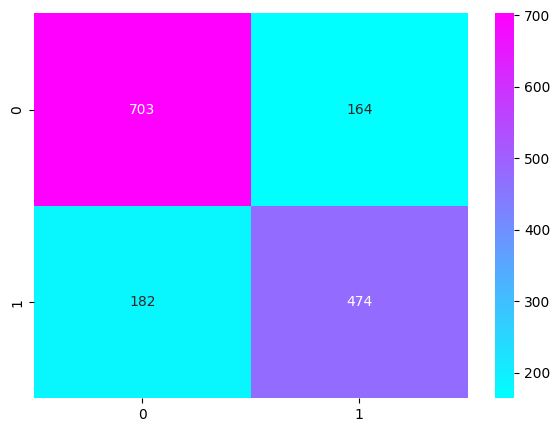

In [66]:
conm = confusion_matrix(y_valid, y_pred5)
plt.figure(figsize=(7, 5))
sns.heatmap(conm, annot=True, fmt='d', cmap='cool')
plt.show()

In [67]:
print(classification_report(y_valid, y_pred5))

              precision    recall  f1-score   support

           0       0.79      0.81      0.80       867
           1       0.74      0.72      0.73       656

    accuracy                           0.77      1523
   macro avg       0.77      0.77      0.77      1523
weighted avg       0.77      0.77      0.77      1523



As Accuracy, Precision, recall and F1 score are above 70 % this model can be considered as good model.

### 4-4. Submission
For submission stopwords are not removing, as words like 'not' has a major role in distinguishing disaster and non-disaster tweet.

In [69]:
test_data = pd.read_csv('../input/nlp-getting-started/test.csv')
test_data['clean_text'] = test_data['text'].apply(toclean_text)
test_data["clean_text"] = test_data["clean_text"].apply(clean_tweet)
test_data.head()

,id,keyword,location,text,clean_text
0,0,NaN,NaN,Just happened a terrible car crash,Just happened a terrible car crash
1,2,NaN,NaN,"Heard about #earthquake is different cities, s...",Heard about earthquake is different cities sta...
2,3,NaN,NaN,"there is a forest fire at spot pond, geese are...",there is a forest fire at spot pond geese are ...
3,9,NaN,NaN,Apocalypse lighting. #Spokane #wildfires,Apocalypse lighting Spokane wildfires
4,11,NaN,NaN,Typhoon Soudelor kills 28 in China and Taiwan,Typhoon Soudelor kills NUMBER in China and Tai...


In [71]:
max_features = 3000
tokenizer = Tokenizer(num_words=max_features, split=' ')
tokenizer.fit_on_texts(test_data['clean_text'].values)
X = tokenizer.texts_to_sequences(test_data['clean_text'].values)
X = pad_sequences(X)
y_hat = model5.predict(X).round()

102/102 [==============================] - 1s 7ms/step


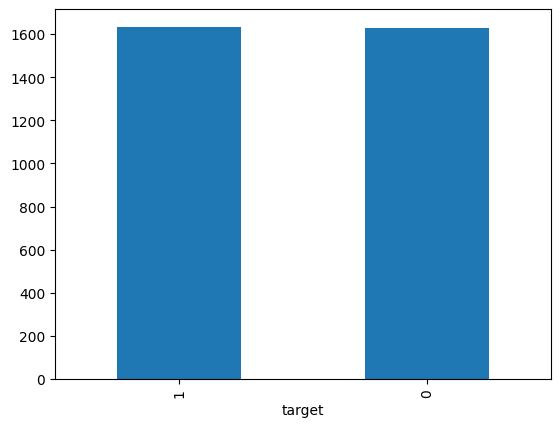

In [73]:
submission = pd.read_csv("/kaggle/input/nlp-getting-started/sample_submission.csv")
submission['target'] = np.round(y_hat).astype('int')
submission.to_csv('submission.csv', index=False)
submission.target.value_counts().plot.bar();

## 5. Conclusion
In this project, we build a machine learning model, that would predict which tweets are about real disasters and which ones are not. The models employed LSTM with different architectures and hyperparameters. In the best model for this round, the accuracy, recall, and precision on the training data exceeded 0.7, indicating a reasonably good model. However, the results on the submission data were only 0.51, indicating that the model didn't perform well. To make improvements in the future, attempts such as increasing max_features or stacking LSTM layers may be necessary.

## References
1. Addison Howard, devrishi, Phil Culliton, Yufeng Guo. (2019). Natural Language Processing with Disaster Tweets. Kaggle. https://kaggle.com/competitions/nlp-getting-started